## Data loading

In [1]:
import h5py
import numpy as np
from pathlib import Path

In [2]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


In [4]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !unzip '/content/drive/My Drive/PatternRecognition/data.zip' -d '/content/data'
    data_dir = Path("./data/") / "Final Project data"
else:
  data_dir = Path("./data/")

assert data_dir.is_dir()
intra_dir = data_dir / "Intra"
cross_dir = data_dir / "Cross"
cross_train_glob = list((cross_dir / "train").glob("*.h5"))
cross_test1_glob = list((cross_dir / "test1").glob("*.h5"))
cross_test2_glob = list((cross_dir / "test2").glob("*.h5"))
cross_test3_glob = list((cross_dir / "test3").glob("*.h5"))
print(len(cross_train_glob), len(cross_test1_glob), len(cross_test2_glob))

Mounted at /content/drive
Archive:  /content/drive/My Drive/PatternRecognition/data.zip
   creating: /content/data/Final Project data/
  inflating: /content/data/__MACOSX/._Final Project data  
  inflating: /content/data/Final Project data/.DS_Store  
  inflating: /content/data/__MACOSX/Final Project data/._.DS_Store  
   creating: /content/data/Final Project data/Intra/
  inflating: /content/data/__MACOSX/Final Project data/._Intra  
   creating: /content/data/Final Project data/Cross/
  inflating: /content/data/__MACOSX/Final Project data/._Cross  
  inflating: /content/data/Final Project data/Intra/.DS_Store  
  inflating: /content/data/__MACOSX/Final Project data/Intra/._.DS_Store  
   creating: /content/data/Final Project data/Intra/test/
  inflating: /content/data/__MACOSX/Final Project data/Intra/._test  
   creating: /content/data/Final Project data/Intra/train/
  inflating: /content/data/__MACOSX/Final Project data/Intra/._train  
  inflating: /content/data/Final Project data/

In [5]:
def load_labels(path: Path) -> np.ndarray:
    *task, subject_identifier, chunk = path.stem.split("_")
    if "rest" in task:
        y = 0
    elif 'math' in task:
        y = 1
    elif 'working' in task:
        y = 2
    elif 'motor' in task:
        y = 3
    else:
        assert False, 'unknown task'
    return np.array([y, int(subject_identifier), int(chunk)])

In [6]:
def load_h5(path: Path) -> np.ndarray:
    with h5py.File(path) as f:
        keys = f.keys()
        assert len(keys) == 1, f"Only one key per file, right? {cross_train_glob[0]}"
        matrix = f.get(next(iter(keys)))[()]
    return matrix


cross_train_X = np.stack(list(map(load_h5, cross_train_glob)))
cross_train_labels = np.stack(list(map(load_labels, cross_train_glob)))[:, 0]

In [7]:
#Load first test dataset
cross_test1_X = np.stack(list(map(load_h5, cross_test1_glob)))
cross_test1_labels = np.stack(list(map(load_labels, cross_test1_glob)))[:, 0]

#Load second test dataset
cross_test2_X = np.stack(list(map(load_h5, cross_test2_glob)))
cross_test2_labels = np.stack(list(map(load_labels, cross_test2_glob)))[:, 0]

#Load third test dataset
cross_test3_X = np.stack(list(map(load_h5, cross_test3_glob)))
cross_test3_labels = np.stack(list(map(load_labels, cross_test3_glob)))[:, 0]

# #Combine two datasets
# cross_test_X = np.concatenate([cross_test1_X, cross_test2_X], axis=0)
# cross_test_labels = np.concatenate([cross_test1_labels, cross_test2_labels], axis=0)[:, 0]

print(cross_test1_X.shape, cross_test1_labels.shape)

(16, 248, 35624) (16,)


## Data preprocessing

In [8]:
import numpy as np
import torch

def downsample(data, old_freq, new_freq):
    # Calculate the downsampling factor
    downsample_factor = int(np.round(old_freq / new_freq))
    # Ensure that timesteps are divisible by the downsampling factor
    data = data[:,:,:data.shape[2]//downsample_factor*downsample_factor]
    # Reshape
    reshaped_data = data.reshape(data.shape[0], data.shape[1], -1, downsample_factor)
    # Take the mean along the last axis
    downsampled_data = reshaped_data.mean(axis=-1)
    return downsampled_data

def z_score_normalize(data):
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    # Calculate mean and std along the timesteps
    mean = torch.mean(data_tensor, dim=2, keepdim=True)
    std = torch.std(data_tensor, dim=2, keepdim=True)
    # Perform z-score norm
    normalized_data = (data_tensor - mean) / std
    return normalized_data

cross_train_X_norm = z_score_normalize(downsample(cross_train_X, 2034, 30))
cross_test1_X_norm = z_score_normalize(downsample(cross_test1_X, 2034, 30))
cross_test2_X_norm = z_score_normalize(downsample(cross_test2_X, 2034, 30))
cross_test3_X_norm = z_score_normalize(downsample(cross_test3_X, 2034, 30))

print(cross_train_X_norm.shape, cross_test1_X_norm.shape)

torch.Size([64, 248, 523]) torch.Size([16, 248, 523])


## VAR-CNN Architecture
implemented from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6609925/

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Define the neural network module
class VectorAutoregressiveCNN(nn.Module):
    def __init__(self, k, l, l1, input_width = 1, input_channels=248, n_classes=4, input_height=523):
        super(VectorAutoregressiveCNN, self).__init__()
        #2D Conv
        self.conv = nn.Conv2d(input_channels, k, (l, 1))
        # Max Pooling
        self.pool = nn.MaxPool2d((2, 1), stride=(2, 1))
        # Calculate output shape after conv and pool
        conv_output_height = (input_height - l + 1) // 2
        conv_output_width = 1
        ninputs = k * conv_output_height * conv_output_width
        #Fully Connected Layer
        self.fc = nn.Linear(ninputs, n_classes)
        self.l1_penalty = l1

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def l1_regularization(self):
        l1_norm = sum(p.abs().sum() for p in self.parameters())
        return self.l1_penalty * l1_norm

#Define hyperparameters
lr, weight_decay, batch_size, num_epochs, k, l, l1 = 1e-3, 1e-2, 32, 30, 64, 7, 1e-4

#Instantiate model
model = VectorAutoregressiveCNN(k=k, l=l, l1=l1)

#Instantiate optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Set device to GPU
device = torch.device("cuda")
model.to(device)

# Define cost
loss_function = nn.CrossEntropyLoss()

## Prepare data for training

In [63]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

#Load training and test sets
dataset = TensorDataset(torch.tensor(cross_train_X_norm.unsqueeze(-1)), torch.tensor(cross_train_labels).long())
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset_1 = TensorDataset(torch.tensor(cross_test1_X_norm.unsqueeze(-1)), torch.tensor(cross_test1_labels).long())
test_dataset_2 = TensorDataset(torch.tensor(cross_test2_X_norm.unsqueeze(-1)), torch.tensor(cross_test2_labels).long())
test_dataset_3 = TensorDataset(torch.tensor(cross_test3_X_norm.unsqueeze(-1)), torch.tensor(cross_test3_labels).long())

test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=batch_size, shuffle=True)

test_loaders = [test_loader_1, test_loader_2, test_loader_3]
num_datasets = len(test_loaders)

<ipython-input-63-3293aeaf5821>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(cross_train_X_norm.unsqueeze(-1)), torch.tensor(cross_train_labels).long())
<ipython-input-63-3293aeaf5821>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset_1 = TensorDataset(torch.tensor(cross_test1_X_norm.unsqueeze(-1)), torch.tensor(cross_test1_labels).long())
<ipython-input-63-3293aeaf5821>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset_2 = TensorDataset(torch.tensor(cross_test2_X_norm.unsqu

## GridSearch

In [ ]:
# from sklearn.model_selection import ParameterGrid

# #The following hyperparameters were searched before arriving at the current ones:
# param_grid = {
#     'lr': [0.00001, 0.0001, 0.001],
#     'weight_decay': [1e-4, 1e-3, 1e-2],
#     'batch_size': [8, 16, 32],
#     'num_epochs': [10, 20, 30],
#     'k':[16, 32, 64],
#     'l':[3, 5, 7],
#     'l1': [1e-4, 1e-3, 1e-2]
# }

# import numpy as np
# from torch.utils.data import DataLoader
# from torch.utils.data.dataset import TensorDataset
# from sklearn.model_selection import ParameterGrid

# batch_size = 8
# num_epochs = 30

# dataset = TensorDataset(torch.tensor(cross_train_X_norm.unsqueeze(-1)), torch.tensor(cross_train_labels).long())
# train_loader = DataLoader(dataset, batch_size=30, shuffle=True)

# test_dataset = TensorDataset(torch.tensor(cross_test_X_norm.unsqueeze(-1)), torch.tensor(cross_test_labels).long())
# test_loader = DataLoader(test_dataset, batch_size=30, shuffle=True)

# best_loss = np.inf
# patience_counter = 0

# # Reset the early stopping patience
# patience_counter = 0
# best_loss = np.inf

# train_losses = []
# train_accuracies = []
# test_losses = []
# test_accuracies = []

# grid = ParameterGrid(param_grid)
# best_params = None
# best_test_loss = np.inf


# for params in grid:
#   batch_size = params['batch_size']
#   num_epochs = params['num_epochs']
#   model = VectorAutoregressiveCNN(params['k'], params['l'], params['l1'] )
#   optimizer = Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
#   model.to(device)

#   for epoch in range(num_epochs):

#     train_loss = 0.0
#     correct_predictions = 0
#     total_predictions = 0

#     # Training
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_function(output, target) + model.l1_regularization()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#         # Curr Accuracy
#         _, predicted = torch.max(output.data, 1)
#         total_predictions += target.size(0)
#         correct_predictions += (predicted == target).sum().item()

#     # Average loss and accuracy over the epoch
#     train_loss /= len(dataset)
#     train_accuracy = correct_predictions / total_predictions

#     # Validation
#     model.eval()
#     test_loss = 0.0
#     correct_predictions = 0
#     total_predictions = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += loss_function(output, target).item()  # Sum up batch loss

#             # Curr Accuracy
#             _, predicted = torch.max(output.data, 1)
#             total_predictions += target.size(0)
#             correct_predictions += (predicted == target).sum().item()


#     test_loss /= len(test_loader.dataset)  # Get the average loss
#     test_accuracy = correct_predictions / total_predictions


#     # Early stopping logic
#     if test_loss < best_loss:
#         # print(f"For params: {params}")
#         # print(f"Training loss: {train_loss}, Training accuracy: {train_accuracy}")
#         # print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
#         patience_counter = 0
#         best_params = params
#         #save the model
#         checkpoint = {
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'epoch': epoch,
#             'best_loss': best_loss,
#             'best_accuracy': test_accuracy}
#         torch.save(checkpoint, f'cnn_checkpoint.pt')
#         #print(f"Checkpoint saved at epoch {epoch}")

# # Print the best parameters after the loop
# print(f"Best Hyperparameters: {best_params}, Training loss: {train_loss}, Testing loss: {test_loss}, Training accuracy: {train_accuracy}, Testing accuracy: {test_accuracy}")

## Training

In [70]:
import numpy as np

# Initialize lists to store results
train_losses = []
train_accuracies = []
test_losses = [[] for _ in range(num_datasets)]
test_accuracies = [[] for _ in range(num_datasets)]
train_class_accuracies = []
per_class_accuracies = [[] for _ in range(num_datasets)]

n_classes = 4

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    class_correct = [0] * n_classes
    class_total = [0] * n_classes

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target) + model.l1_regularization()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Curr Accuracy
        _, predicted = torch.max(output.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        # Per-class accuracy
        for i in range(n_classes):
            class_total[i] += (target == i).sum().item()
            class_correct[i] += (predicted == i)[target == i].sum().item()

    # Average loss and accuracy over the epoch
    train_loss /= len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Per-class accuracy
    per_class_accuracy = [class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(n_classes)]
    train_class_accuracies.append(per_class_accuracy)

    # Testing on multiple datasets
    for i, test_loader in enumerate(test_loaders):
        model.eval()
        test_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        class_correct = [0] * n_classes
        class_total = [0] * n_classes

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += loss_function(output, target).item()  # Sum up batch loss

                # Curr Accuracy
                _, predicted = torch.max(output.data, 1)
                total_predictions += target.size(0)
                correct_predictions += (predicted == target).sum().item()

                # Per-class accuracy
                for c in range(n_classes):
                    class_total[c] += (target == c).sum().item()
                    class_correct[c] += (predicted == c)[target == c].sum().item()

        # Average loss and accuracy over the epoch
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct_predictions / total_predictions

        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_accuracy)

        # Per-class accuracy
        per_class_accuracy = [class_correct[c] / class_total[c] if class_total[c] != 0 else 0 for c in range(n_classes)]
        per_class_accuracies[i].append(per_class_accuracy)

# Calculate the average accuracy across all datasets
avg_test_accuracies = [np.mean(acc) for acc in test_accuracies]

## Results

In [71]:
# 1) Overall accuracy of all datasets
overall_accuracy = np.mean(avg_test_accuracies)
print(f"Overall Accuracy (All Datasets): {overall_accuracy:.4f}")

# 2) 3 overall accuracies (one for each dataset)
for i, avg_acc in enumerate(avg_test_accuracies):
    print(f"Overall Accuracy (Dataset {i + 1}): {avg_acc:.4f}")

# 3) 4 accuracies (1 per class)
for i in range(n_classes):
    class_accuracies = [per_class_accuracies[j][epoch][i] for j in range(num_datasets)]
    avg_class_accuracy = np.mean(class_accuracies)
    print(f"Class {i + 1} Accuracy: {avg_class_accuracy:.4f}")


Overall Accuracy (All Datasets): 0.6097
Overall Accuracy (Dataset 1): 0.5500
Overall Accuracy (Dataset 2): 0.6208
Overall Accuracy (Dataset 3): 0.6583
Class 1 Accuracy: 1.0000
Class 2 Accuracy: 0.5000
Class 3 Accuracy: 0.9167
Class 4 Accuracy: 0.4167


## Plot performance

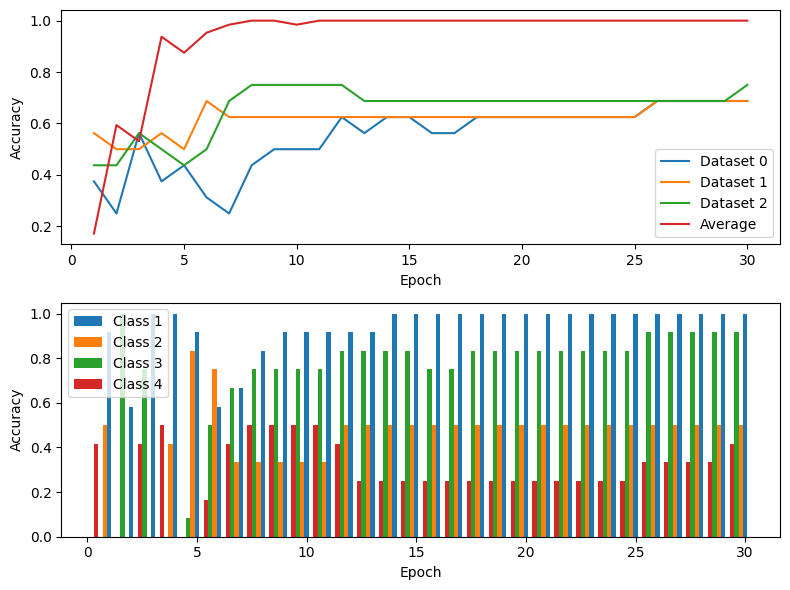

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already run the modified training loop

# Extracting data for plotting
epoch_numbers = list(range(1, num_epochs + 1))

# 2) 3 overall accuracies (one for each dataset)
dataset_accuracies = [avg_test_accuracies] + test_accuracies

# 3) 4 accuracies (1 per class)
class_accuracies = [[np.mean([per_class_accuracies[j][epoch][i] for j in range(num_datasets)]) for i in range(n_classes)] for epoch in range(num_epochs)]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Line plot for accuracies per dataset
for i in range(num_datasets + 1):  # One line for the average accuracy
  if i == 3:
    label = 'Average'
    ax1.plot(epoch_numbers, train_accuracies, label=label)
  else:
    label = f'Dataset {i}'
    ax1.plot(epoch_numbers, test_accuracies[i], label=label)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Bar plot for accuracies per class
for i in range(n_classes):
    ax2.bar(np.array(epoch_numbers) - 0.2 * i, [class_accuracies[epoch][i] for epoch in range(num_epochs)], width=0.2, label=f'Class {i + 1}')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


#### Further Training (optional)

Load the model checkpoint

In [ ]:
model = VectorAutoregressiveCNN(input_channels, k, l, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Load the model and optimizer state_dict
checkpoint = torch.load('cnn_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()  # For inference
model.train()  # For further training